In this notebook, we attempt to model 'award-worthiness' using various tree based models and a mean-field approach to the cohort effects.

In [1]:
%load_ext autoreload
%autoreload 2
# standard imports
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

In [2]:
shortlists = pd.read_csv("../data/train_novels.csv")
shortlists.head()

,author_qid,pubDate,goodreads_id,title,authorLabel,work_qid,year,n_nom,n_win,awards_as_of_year,age,birth_country,gender,topicality,max,count,median
0,Q1006918,1965-01-01T00:00:00Z,NaN,The Ship That Sailed the Time Stream,G. C. Edmondson,Q122452512,1966,1,0,0,44.0,United States,male,0.219992,NaN,NaN,NaN
1,Q1029497,2006-11-28T00:00:00Z,NaN,Carnival,Elizabeth Bear,Q25217435,2007,2,0,1,36.0,United States,female,0.169624,NaN,NaN,NaN
2,Q1029497,2007-08-01T00:00:00Z,NaN,Undertow,Elizabeth Bear,Q131381664,2008,1,0,4,37.0,United States,female,0.245872,NaN,NaN,NaN
3,Q1029497,2010-02-20T00:00:00Z,NaN,Chill,Elizabeth Bear,Q131382134,2011,1,0,13,40.0,United States,female,-0.195356,NaN,NaN,NaN
4,Q1029497,2011-02-22T00:00:00Z,NaN,Grail,Elizabeth Bear,Q131382162,2012,1,0,15,41.0,United States,female,0.182915,NaN,NaN,NaN


As it stands, the data in `shortlists` has a row per novel author pair.
We want to first flatten this so that we have one entry for each book on the short lists.

In [3]:
shortlists.columns

Index(['author_qid', 'pubDate', 'goodreads_id', 'title', 'authorLabel',
       'work_qid', 'year', 'n_nom', 'n_win', 'awards_as_of_year', 'age',
       'birth_country', 'gender', 'topicality', 'max', 'count', 'median'],
      dtype='object')

In [4]:
safe_to_drop = ["author_qid", "goodreads_id", "title", "authorLabel"]
shortlists.drop(columns=safe_to_drop, inplace=True)

shortlists.head()

,pubDate,work_qid,year,n_nom,n_win,awards_as_of_year,age,birth_country,gender,topicality,max,count,median
0,1965-01-01T00:00:00Z,Q122452512,1966,1,0,0,44.0,United States,male,0.219992,NaN,NaN,NaN
1,2006-11-28T00:00:00Z,Q25217435,2007,2,0,1,36.0,United States,female,0.169624,NaN,NaN,NaN
2,2007-08-01T00:00:00Z,Q131381664,2008,1,0,4,37.0,United States,female,0.245872,NaN,NaN,NaN
3,2010-02-20T00:00:00Z,Q131382134,2011,1,0,13,40.0,United States,female,-0.195356,NaN,NaN,NaN
4,2011-02-22T00:00:00Z,Q131382162,2012,1,0,15,41.0,United States,female,0.182915,NaN,NaN,NaN


In [5]:
from models.prepare import prepare_df
prepare_df(shortlists)


,work_qid,year,n_win,topicality,max_bestseller_rank,months_on_bestseller,median_bestseller_rank,mean_age,gender,birth_country,awards_as_of_year,n_nom_all,month,tot_cohort_nom,tot_cohort_awards
0,Q1213656,1959,0,0.221080,0.0,0.0,0.0,52.0,[male],[United States],0,1,8.0,5,1
1,Q18208798,1959,0,0.190188,0.0,0.0,0.0,33.0,[male],[United States],0,1,8.0,5,1
2,Q586831,1959,1,0.228423,0.0,0.0,0.0,38.0,[male],[United States],1,1,1.0,5,1
3,Q519935,1959,0,0.267346,0.0,0.0,0.0,31.0,[male],[United States],1,1,1.0,5,1
4,Q3414362,1959,0,0.202211,0.0,0.0,0.0,28.0,[male],[Prussia],2,1,1.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,Q55653446,2018,0,-0.119301,0.0,0.0,0.0,38.0,[female],[United States],8,2,2.0,56,5
1453,Q131414152,2018,0,0.111775,0.0,0.0,0.0,76.0,[male],[United States],21,1,10.0,56,5
1454,Q100324066,2018,0,0.101054,0.0,0.0,0.0,50.0,[female],[Hungary],15,2,6.0,56,5
1455,Q131382750,2018,0,-0.096929,0.0,0.0,0.0,52.0,[female],[Russia],2,1,7.0,56,5


In [6]:
from sklearn.metrics import f1_score
from models.prepare import prepare_df
from models.naive import naive_win_counts

X_train = prepare_df(shortlists)
y_train = X_train.pop("n_win")

N_baseline_runs = 1000
baseline_f1s = np.zeros(N_baseline_runs)

for i in range(N_baseline_runs):
    baseline_f1s[i] = f1_score(y_train > 0, naive_win_counts(X_train) > 0)

print(f"Mean F_1 for naive model: {baseline_f1s.mean()}")
print(f"Stddev of F_1 for naive model: {baseline_f1s.std()}")

Mean F_1 for naive model: 0.22925734635933537
Stddev of F_1 for naive model: 0.02656275419941662


In [40]:

from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GroupKFold
from models.transformers import RowCountEncoder

def impute_topicality(df):
    return df.assign(
        topicality=df.groupby("year")["topicality"].transform(
            lambda x: x.fillna(x.mean())
        )
    )

dt_pipeline = Pipeline(
    [
        ("impute_topicality", FunctionTransformer(impute_topicality)),
        (
            "encode_author_data",
            RowCountEncoder(["gender", "birth_country"], "work_qid"),
        ),
        ('drop', FunctionTransformer(lambda df: df.drop(columns=['work_qid', 'month']))),
        ('imputer', SimpleImputer(strategy='median')),
        ('tree', DecisionTreeClassifier(max_depth=3, class_weight='balanced'))
    ]
)

dt_pipeline.set_output(transform="pandas")

cross_val_score(dt_pipeline, X_train, y_train > 0, cv=GroupKFold(n_splits=5), groups=X_train["year"], scoring="f1").mean()   

np.float64(0.3909903160905795)

In [16]:
from sklearn.metrics import confusion_matrix

kfold = GroupKFold(n_splits=5 )
confusion = np.zeros((2,2))
f1_dt = np.zeros(5)
for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train, groups=X_train["year"])):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    dt_pipeline.fit(X_train_fold, y_train_fold>0)
    y_pred = dt_pipeline.predict(X_test_fold)
    confusion += confusion_matrix(y_test_fold>0, y_pred)
    f1_dt[i] = f1_score(y_test_fold>0, y_pred)

print(f"Confusion matrix for decision tree model: {confusion}")
print(f"Mean F_1 for decision tree model: {f1_dt.mean()}")
print(f"Stddev of F_1 for decision tree model: {f1_dt.std()}")

Confusion matrix for decision tree model: [[943. 333.]
 [ 61. 120.]]
Mean F_1 for decision tree model: 0.3909903160905795
Stddev of F_1 for decision tree model: 0.08858273046248365


In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(
    [
        ("impute_topicality", FunctionTransformer(impute_topicality)),
        (
            "encode_author_data",
            RowCountEncoder(["gender", "birth_country"], "work_qid"),
        ),
        ('drop', FunctionTransformer(lambda df: df.drop(columns=['work_qid', 'month']))),
        ('imputer', SimpleImputer(strategy='median')),
        ('tree', RandomForestClassifier(max_depth=3, class_weight='balanced', n_estimators=100))
    ]
)

rf_pipeline.set_output(transform="pandas")

cross_val_score(rf_pipeline, X_train, y_train > 0, cv=GroupKFold(n_splits=5), groups=X_train["year"], scoring="f1").mean()   

np.float64(0.4377550721660513)

In [37]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline(
    [
        ("impute_topicality", FunctionTransformer(impute_topicality)),
        (
            "encode_author_data",
            RowCountEncoder(["gender", "birth_country"], "work_qid"),
        ),
        ('drop', FunctionTransformer(lambda df: df.drop(columns=['work_qid', 'month']))),
        ('imputer', SimpleImputer(strategy='median')),
        ('tree', XGBClassifier(max_depth=4, n_estimators=100,))
    ]
)

xgb_pipeline.set_output(transform="pandas")

cross_val_score(xgb_pipeline, X_train, y_train > 0, cv=GroupKFold(n_splits=5), groups=X_train["year"], scoring="f1").mean()   

np.float64(0.4293453756018815)

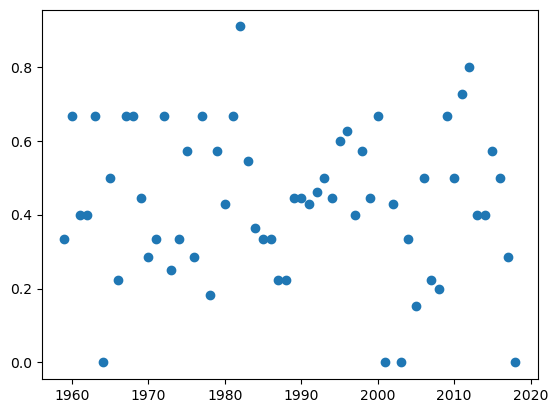

In [49]:
years = shortlists["year"].unique()
years.sort()
f1_by_year = np.zeros(len(years))

for i, year in enumerate(years):
    year_indices = X_train["year"] == year
    X_train_year = X_train[~year_indices]
    y_train_year = y_train[~year_indices]
    X_test_year = X_train[year_indices]
    y_test_year = y_train[year_indices]
    rf_pipeline.fit(X_train_year, y_train_year > 0)
    y_pred = rf_pipeline.predict(X_test_year)
    f1_by_year[i] = f1_score(y_test_year > 0, y_pred)

plt.scatter(years, f1_by_year)